In [66]:
%%capture --no-stderr
%pip install -r requirements.txt

In [2]:
%reload_ext dotenv
%dotenv

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from IPython.display import HTML
import os

PASCAL Visual Object Classes
http://host.robots.ox.ac.uk/pascal/VOC/

In [4]:
# Load Pascal VOC dataset
dataset_path = os.path.join(os.getenv('DATASETS_BASE'), 'VOC')
train_dataset = datasets.VOCDetection(dataset_path, year='2012', image_set='train', download=True)
trainval_dataset = datasets.VOCDetection(dataset_path, year='2012', image_set='trainval', download=True)
val_dataset = datasets.VOCDetection(dataset_path, year='2012', image_set='val', download=True)

Using downloaded and verified file: /Users/anton/datasets/VOC/VOCtrainval_11-May-2012.tar
Extracting /Users/anton/datasets/VOC/VOCtrainval_11-May-2012.tar to /Users/anton/datasets/VOC
Using downloaded and verified file: /Users/anton/datasets/VOC/VOCtrainval_11-May-2012.tar
Extracting /Users/anton/datasets/VOC/VOCtrainval_11-May-2012.tar to /Users/anton/datasets/VOC
Using downloaded and verified file: /Users/anton/datasets/VOC/VOCtrainval_11-May-2012.tar
Extracting /Users/anton/datasets/VOC/VOCtrainval_11-May-2012.tar to /Users/anton/datasets/VOC


In [8]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Trainval dataset size: {len(trainval_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")

Train dataset size: 5717
Trainval dataset size: 11540
Val dataset size: 5823


In [13]:
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=500x442>,
 {'annotation': {'folder': 'VOC2012',
   'filename': '2008_000008.jpg',
   'source': {'database': 'The VOC2008 Database',
    'annotation': 'PASCAL VOC2008',
    'image': 'flickr'},
   'size': {'width': '500', 'height': '442', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'horse',
     'pose': 'Left',
     'truncated': '0',
     'occluded': '1',
     'bndbox': {'xmin': '53', 'ymin': '87', 'xmax': '471', 'ymax': '420'},
     'difficult': '0'},
    {'name': 'person',
     'pose': 'Unspecified',
     'truncated': '1',
     'occluded': '0',
     'bndbox': {'xmin': '158', 'ymin': '44', 'xmax': '289', 'ymax': '167'},
     'difficult': '0'}]}})

In [18]:
train_filenames     = set([x[1]['annotation']['filename'] for x in train_dataset])
trainval_filenames  = set([x[1]['annotation']['filename'] for x in trainval_dataset])
val_filenames       = set([x[1]['annotation']['filename'] for x in val_dataset])
is_union = trainval_filenames == (train_filenames | val_filenames)
print(f"Is trainval a union of train and val? {is_union}")

Is trainval a union of train and val? True


In [21]:
# Calculate average, min, and max width and height for train dataset
widths = []
heights = []
depths = set()

for _, target in train_dataset:
    width = int(target['annotation']['size']['width'])
    height = int(target['annotation']['size']['height'])
    widths.append(width)
    heights.append(height)
    depth = int(target['annotation']['size']['depth'])
    depths.add(depth)

avg_width = sum(widths) / len(widths)
avg_height = sum(heights) / len(heights)

min_width = min(widths)
min_height = min(heights)

max_width = max(widths)
max_height = max(heights)

print(f"Train dataset statistics:")
print(f"Average width: {avg_width:.2f}, Average height: {avg_height:.2f}")
print(f"Min width: {min_width}, Min height: {min_height}")
print(f"Max width: {max_width}, Max height: {max_height}")
print(f"Depth: {depths}")

Train dataset statistics:
Average width: 471.68, Average height: 385.27
Min width: 142, Min height: 111
Max width: 500, Max height: 500
Depth: {3}


Number of segmented images: 1151
Percentage of segmented images: 20.13%


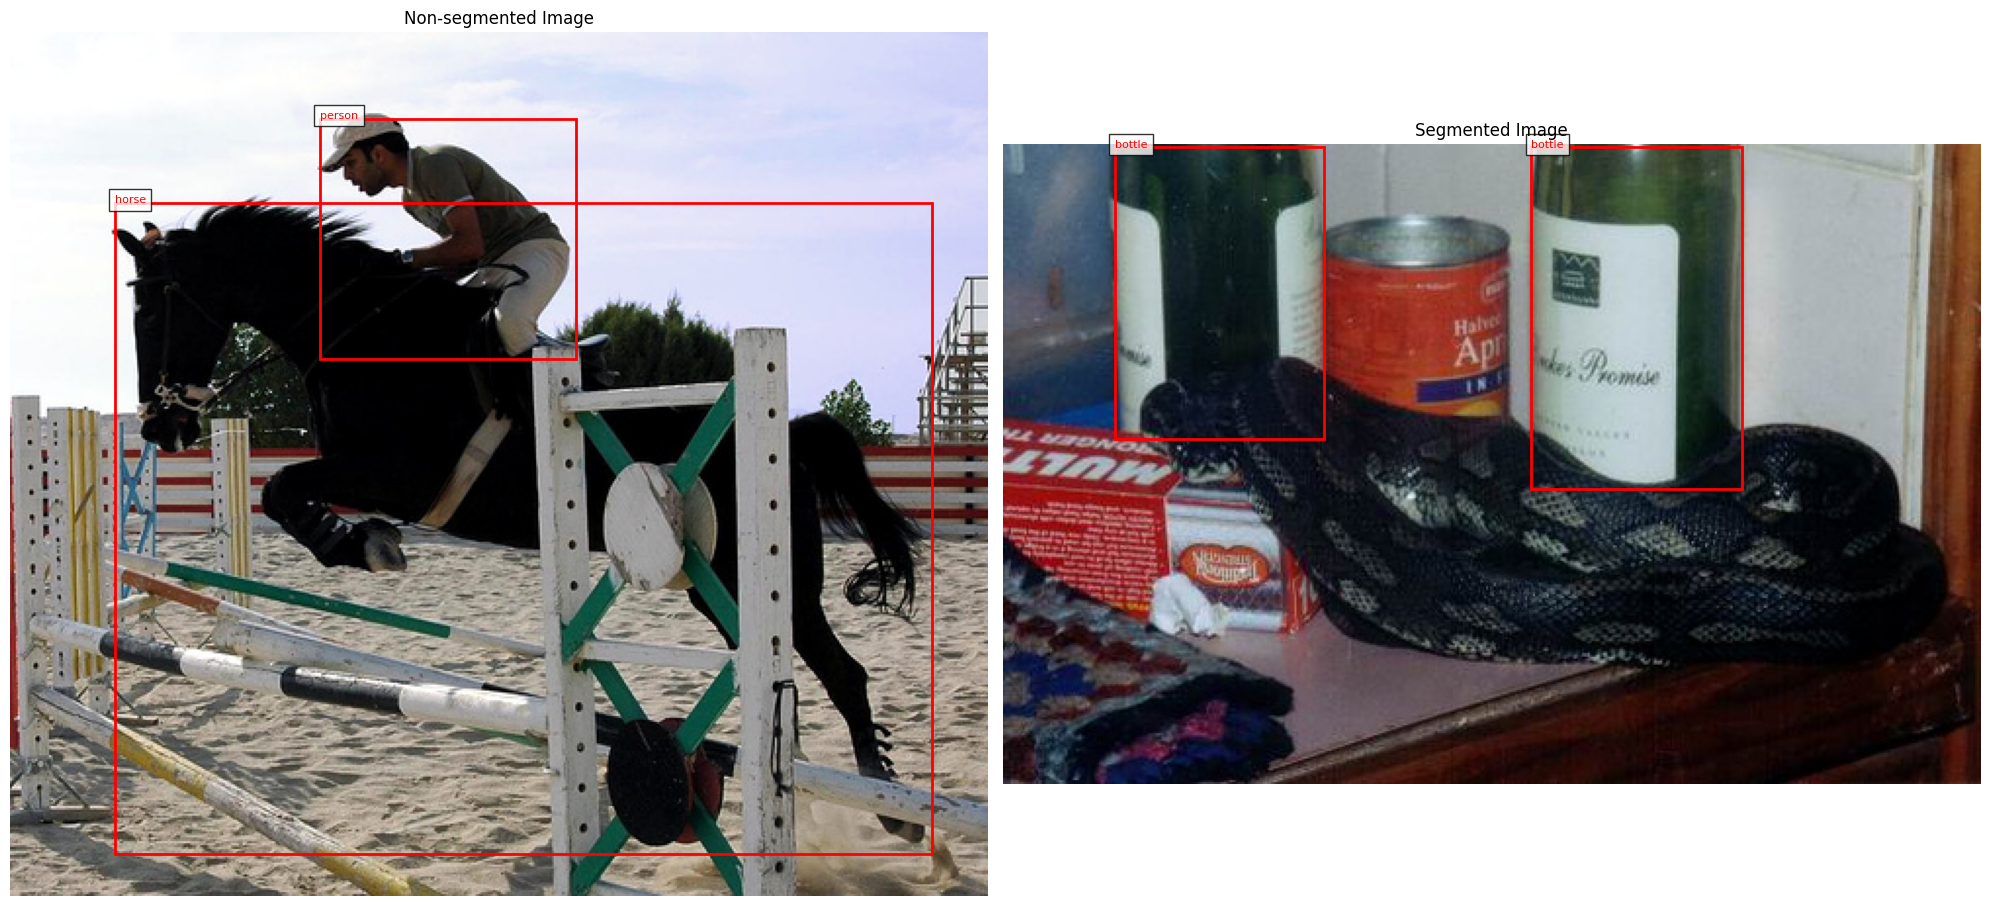

In [28]:
# Check for segmented images in the train dataset
segmented_count = 0
total_count = len(train_dataset)

for _, target in train_dataset:
    if target['annotation']['segmented'] == '1':
        segmented_count += 1

print(f"Number of segmented images: {segmented_count}")
print(f"Percentage of segmented images: {(segmented_count / total_count) * 100:.2f}%")

# Find one non-segmented and one segmented image
non_segmented_image = None
segmented_image = None

for img, target in train_dataset:
    if target['annotation']['segmented'] == '0' and non_segmented_image is None:
        non_segmented_image = (img, target)
    elif target['annotation']['segmented'] == '1' and segmented_image is None:
        segmented_image = (img, target)
    
    if non_segmented_image and segmented_image:
        break

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Display non-segmented image
ax1.imshow(non_segmented_image[0])
ax1.set_title("Non-segmented Image")
ax1.axis('off')

# Draw bounding boxes for non-segmented image
objects = non_segmented_image[1]['annotation'].get('object', [])
if not isinstance(objects, list):
    objects = [objects]

for obj in objects:
    bbox = obj['bndbox']
    xmin, ymin, xmax, ymax = [int(bbox[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax1.add_patch(rect)
    ax1.text(xmin, ymin, obj['name'], color='r', fontsize=8, 
             bbox=dict(facecolor='white', alpha=0.8))

# Display segmented image
ax2.imshow(segmented_image[0])
ax2.set_title("Segmented Image")
ax2.axis('off')

# Draw bounding boxes for segmented image
objects = segmented_image[1]['annotation'].get('object', [])
if not isinstance(objects, list):
    objects = [objects]

for obj in objects:
    bbox = obj['bndbox']
    xmin, ymin, xmax, ymax = [int(bbox[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    ax2.text(xmin, ymin, obj['name'], color='r', fontsize=8, 
             bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [22]:
# Calculate number of objects statistics for train dataset
num_objects = []

for _, target in train_dataset:
    objects = target['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]
    num_objects.append(len(objects))

min_objects = min(num_objects)
max_objects = max(num_objects)
avg_objects = sum(num_objects) / len(num_objects)

print(f"Number of objects in train dataset:")
print(f"Minimum: {min_objects}")
print(f"Maximum: {max_objects}")
print(f"Average: {avg_objects:.2f}")

Number of objects in train dataset:
Minimum: 1
Maximum: 56
Average: 2.76


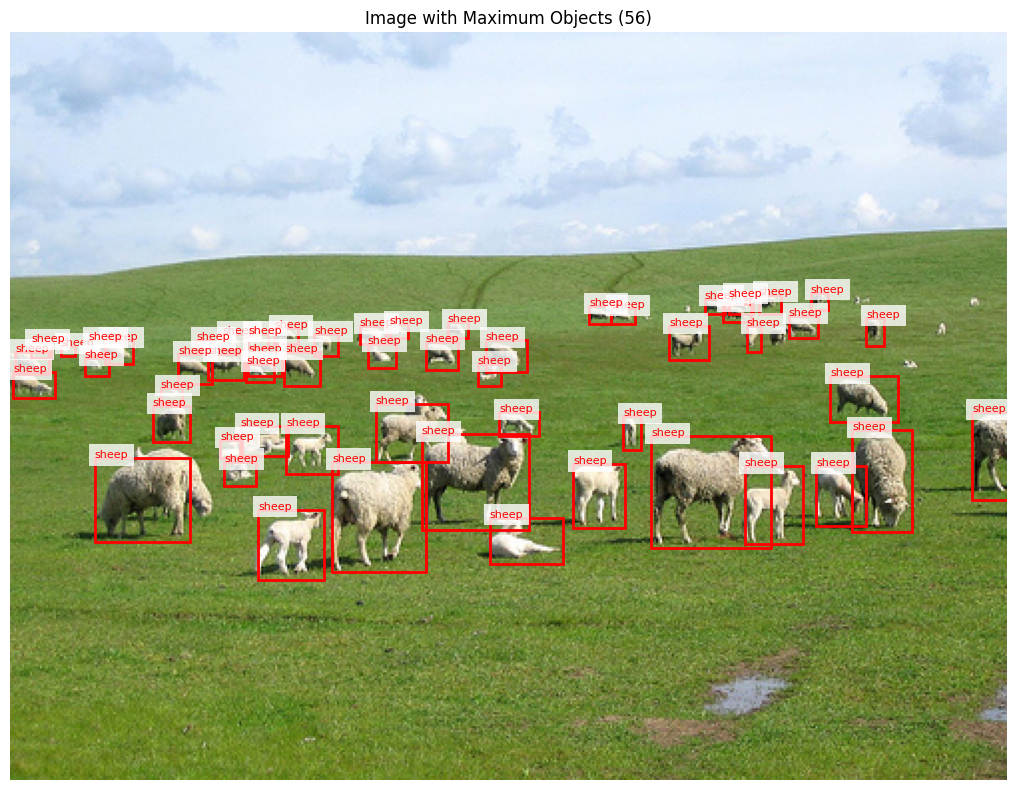

Objects in this image: {'sheep'}


In [26]:
# Find image with the max number of objects
max_objects_index = num_objects.index(max_objects)
max_objects_image, max_objects_target = train_dataset[max_objects_index]

# Convert PIL Image to numpy array
image_np = np.array(max_objects_image)

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Display the image
ax.imshow(image_np)

# Draw bounding boxes
objects = max_objects_target['annotation'].get('object', [])
if not isinstance(objects, list):
    objects = [objects]

for obj in objects:
    bbox = obj['bndbox']
    xmin, ymin, xmax, ymax = [int(bbox[k]) for k in ['xmin', 'ymin', 'xmax', 'ymax']]
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin, obj['name'], color='r', fontsize=8, 
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

ax.set_title(f'Image with Maximum Objects ({max_objects})')
ax.axis('off')

plt.tight_layout()
plt.show()

Total number of objects: 15774
Total number of unique object names: 20

Object names, counts, and percentages:



Poses, counts, and percentages:



Percentage of truncated objects: 51.36%
Percentage of occluded objects: 41.28%
Percentage of difficult objects: 13.73%


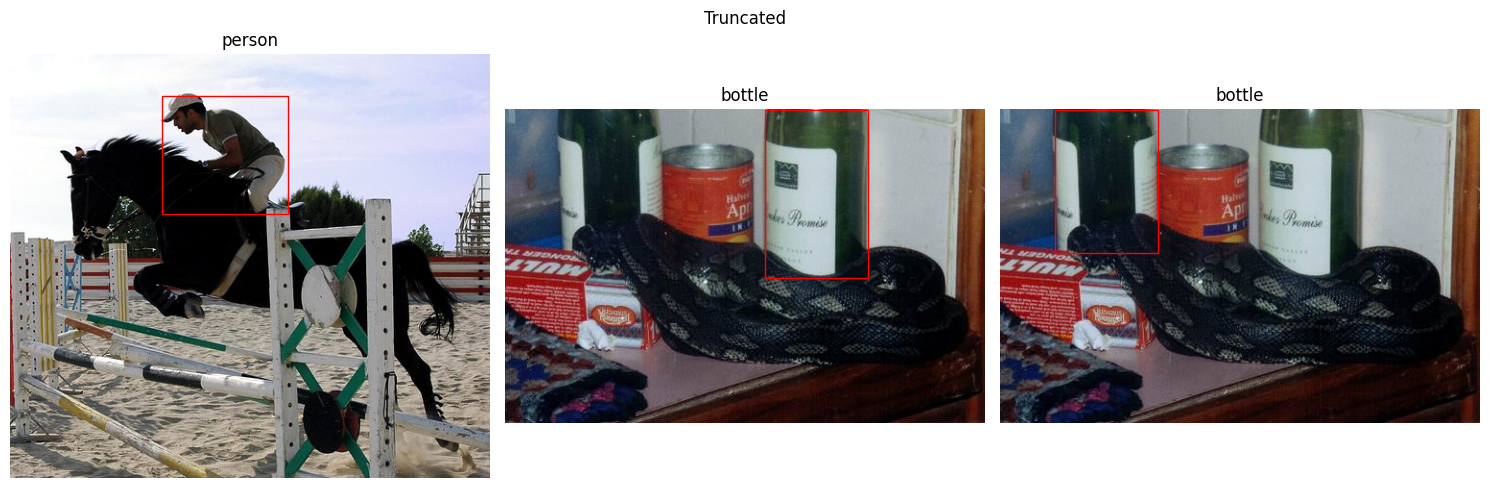

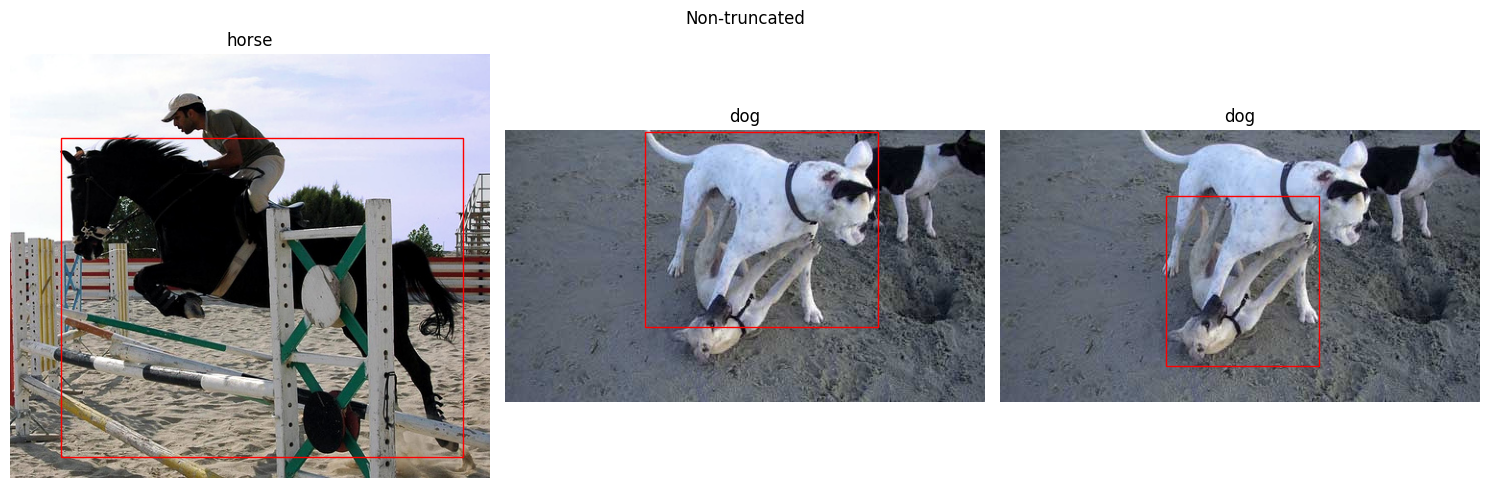

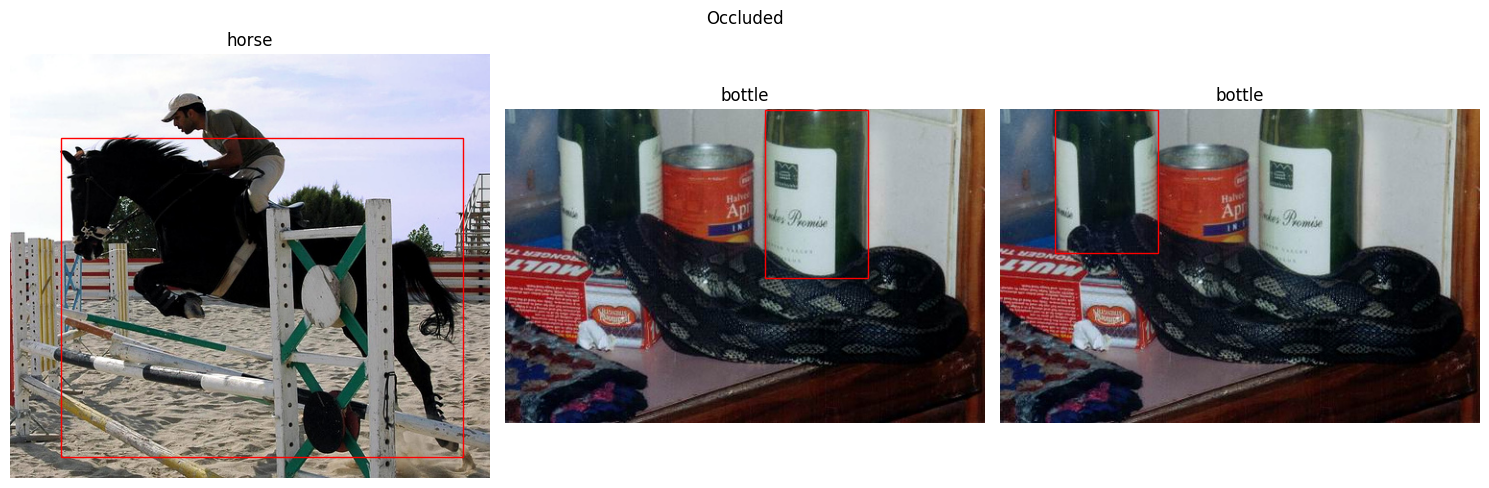

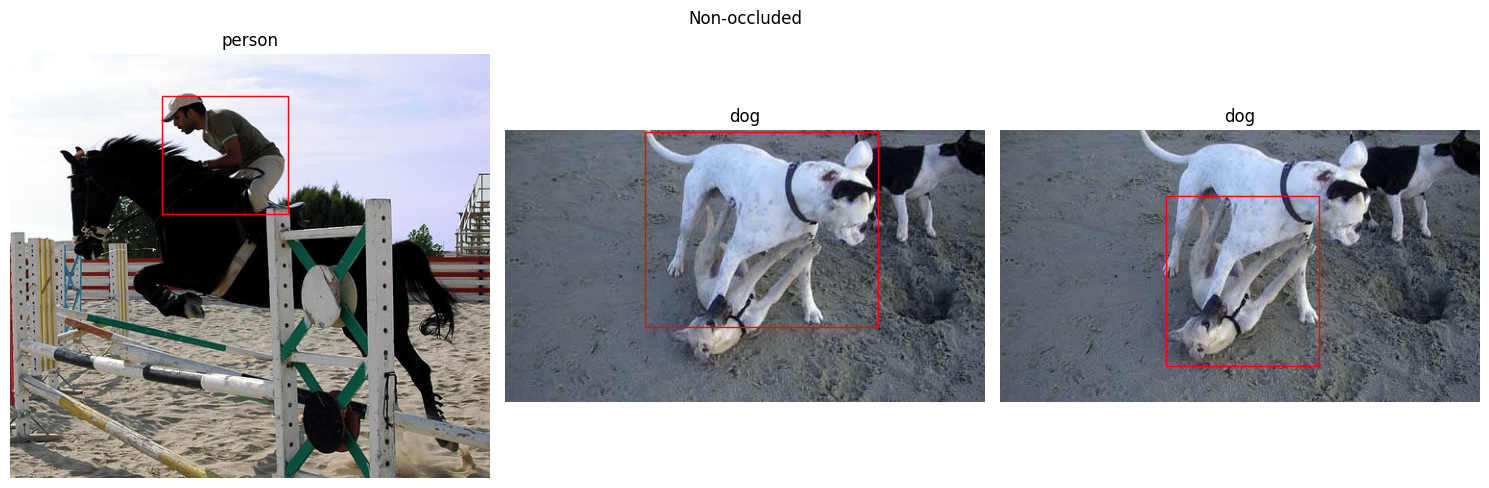

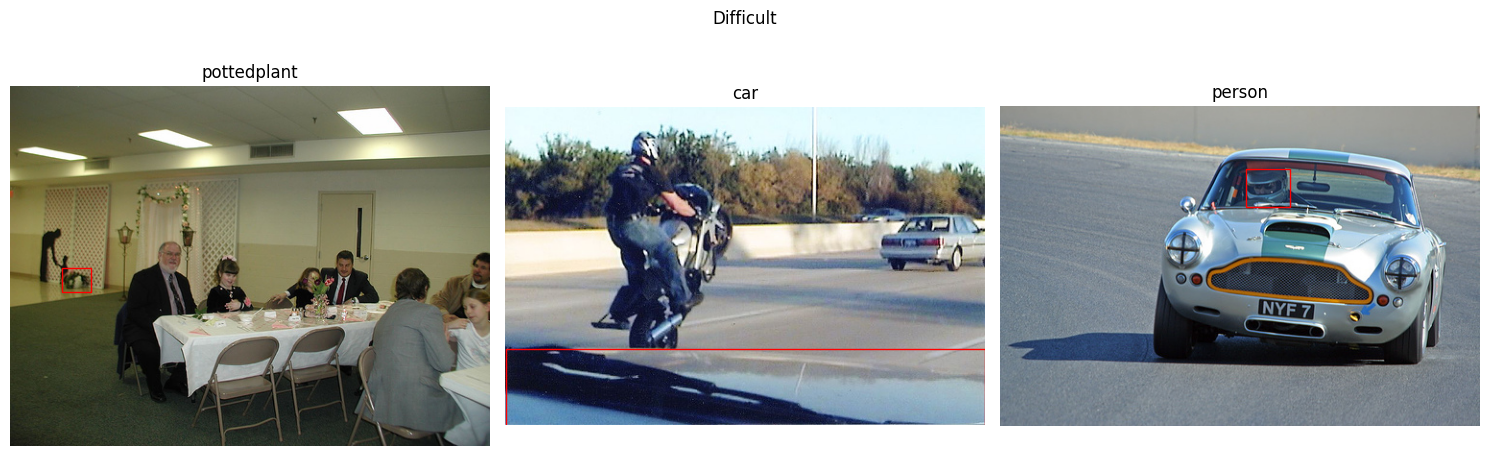

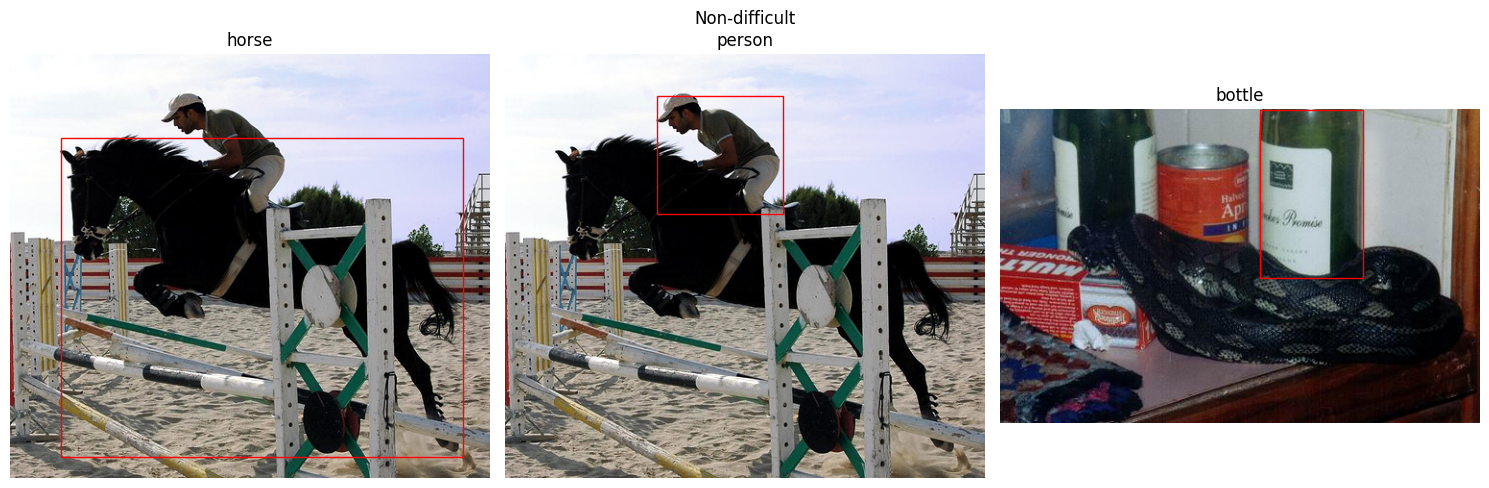

In [60]:
from collections import Counter
from tabulate import tabulate

object_names = Counter()
poses = Counter()
total_objects = 0
truncated_count = 0
occluded_count = 0
difficult_count = 0

truncated_examples = []
non_truncated_examples = []
occluded_examples = []
non_occluded_examples = []
difficult_examples = []
non_difficult_examples = []

for image, target in train_dataset:
    objects = target['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]
    
    for obj in objects:
        object_names[obj['name']] += 1
        poses[obj['pose']] += 1
        total_objects += 1
        
        if obj['truncated'] == '1':
            truncated_count += 1
            if len(truncated_examples) < 3:
                truncated_examples.append((image, obj))
        elif len(non_truncated_examples) < 3:
            non_truncated_examples.append((image, obj))
        
        if obj['occluded'] == '1':
            occluded_count += 1
            if len(occluded_examples) < 3:
                occluded_examples.append((image, obj))
        elif len(non_occluded_examples) < 3:
            non_occluded_examples.append((image, obj))
        
        if obj['difficult'] == '1':
            difficult_count += 1
            if len(difficult_examples) < 3:
                difficult_examples.append((image, obj))
        elif len(non_difficult_examples) < 3:
            non_difficult_examples.append((image, obj))

print(f"Total number of objects: {total_objects}")
print(f"Total number of unique object names: {len(object_names)}")

def create_styled_table(data, columns):
    df = pd.DataFrame(data, columns=columns)
    return df.style.format({'Percentage': '{:.2f}%'}) \
                   .background_gradient(subset=["Percentage"])

def display_table(data, columns):
    styled_df = create_styled_table(data, columns)
    display(HTML(styled_df.to_html()))

# Display object table
object_data = [[name, count, (count / total_objects) * 100] for name, count in object_names.items()]
display_table(object_data, ["Object Name", "Count", "Percentage"])

# Display pose table
pose_data = [[pose, count, (count / total_objects) * 100] for pose, count in poses.items()]
display_table(pose_data, ["Pose", "Count", "Percentage"])

print(f"\nPercentage of truncated objects: {truncated_count/total_objects*100:.2f}%")
print(f"Percentage of occluded objects: {occluded_count/total_objects*100:.2f}%")
print(f"Percentage of difficult objects: {difficult_count/total_objects*100:.2f}%")

# Function to plot examples
def plot_examples(examples, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title)
    for i, (image, obj) in enumerate(examples):
        ax = axes[i]
        ax.imshow(image)
        bbox = obj['bndbox']
        rect = plt.Rectangle((int(bbox['xmin']), int(bbox['ymin'])),
                             int(bbox['xmax']) - int(bbox['xmin']),
                             int(bbox['ymax']) - int(bbox['ymin']),
                             fill=False, edgecolor='red')
        ax.add_patch(rect)
        ax.set_title(obj['name'])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_examples(truncated_examples, "Truncated")
plot_examples(non_truncated_examples, "Non-truncated")

plot_examples(occluded_examples, "Occluded")
plot_examples(non_occluded_examples, "Non-occluded")

plot_examples(difficult_examples, "Difficult")
plot_examples(non_difficult_examples, "Non-difficult")

In the PASCAL VOC dataset, the terms "occluded" and "truncated" describe specific challenges related to the visibility and completeness of objects in images:

1. **Occluded**: An object is considered *occluded* when part of it is obscured by another object or by something in the scene, but the object is still partially visible. For example, if a car is partially hidden behind a tree, the car is occluded. The annotation reflects that only part of the object can be seen due to some form of obstruction.

2. **Truncated**: An object is *truncated* when part of it lies outside the boundaries of the image frame, so the full object is not visible. For instance, if a pedestrian's lower body is cut off at the bottom edge of an image, the object is truncated. This typically happens because the image crop does not include the entire object.

Min width: 3, Min height: 4
Max width: 499, Max height: 499
Average width: 158.98, Average height: 160.03

Typical box sizes (cluster centers):
Cluster 1: Width = 49.52, Height = 56.54
Cluster 2: Width = 437.10, Height = 276.36
Cluster 3: Width = 115.86, Height = 181.26
Cluster 4: Width = 238.49, Height = 350.29
Cluster 5: Width = 263.33, Height = 164.40


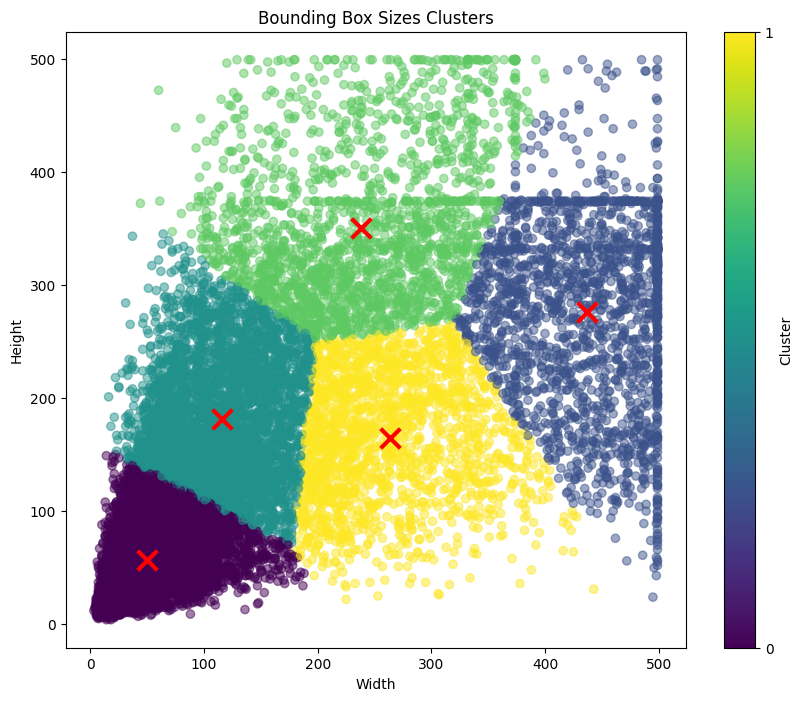

In [68]:
# Calculate box sizes
box_sizes = []
for image, target in train_dataset:
    objects = target['annotation'].get('object', [])
    if not isinstance(objects, list):
        objects = [objects]
    
    for obj in objects:
        bbox = obj['bndbox']
        width = int(bbox['xmax']) - int(bbox['xmin'])
        height = int(bbox['ymax']) - int(bbox['ymin'])
        box_sizes.append([width, height])

box_sizes = np.array(box_sizes)

# Calculate min, max, average widths and heights
min_width, min_height = np.min(box_sizes, axis=0)
max_width, max_height = np.max(box_sizes, axis=0)
avg_width, avg_height = np.mean(box_sizes, axis=0)

print(f"Min width: {min_width}, Min height: {min_height}")
print(f"Max width: {max_width}, Max height: {max_height}")
print(f"Average width: {avg_width:.2f}, Average height: {avg_height:.2f}")

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(box_sizes)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

print("\nTypical box sizes (cluster centers):")
for i, center in enumerate(cluster_centers):
    print(f"Cluster {i+1}: Width = {center[0]:.2f}, Height = {center[1]:.2f}")

# Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(box_sizes[:, 0], box_sizes[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, linewidths=3)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Bounding Box Sizes Clusters')
plt.colorbar(ticks=range(5), label='Cluster')
plt.show()

The average silhouette score is: 0.448


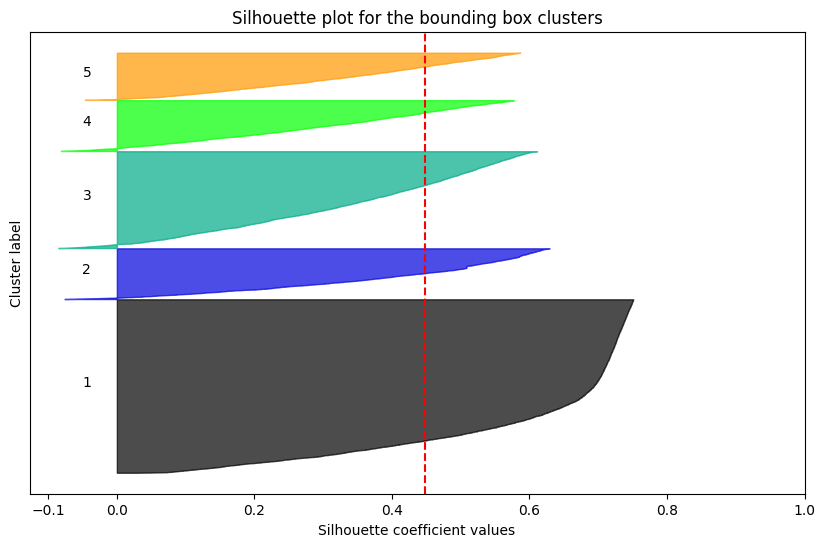

In [89]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Compute the silhouette scores
silhouette_avg = silhouette_score(box_sizes, kmeans.labels_)
sample_silhouette_values = silhouette_samples(box_sizes, kmeans.labels_)

print(f"The average silhouette score is: {silhouette_avg:.3f}")

# Plot the silhouette diagram
plt.figure(figsize=(10, 6))
y_lower = 10

for i in range(len(cluster_centers)):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_ == i]
    ith_cluster_silhouette_values.sort()
    
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 5)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette plot for the bounding box clusters")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


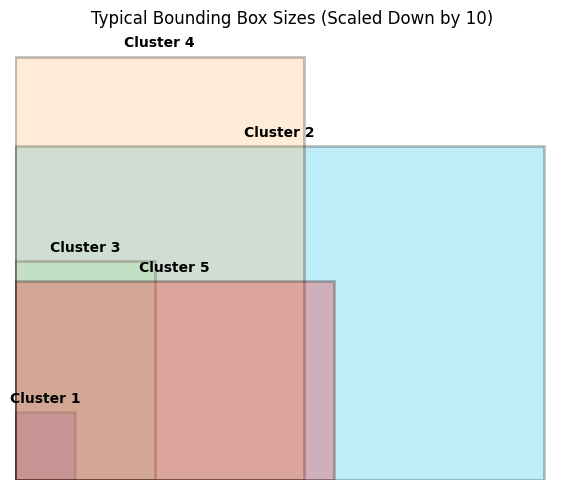

In [88]:
# Visualize typical box sizes
plt.figure(figsize=(15, 5))
colors = plt.cm.rainbow(np.linspace(0, 1, len(cluster_centers)))
for i, (center, color) in enumerate(zip(cluster_centers, colors)):
    width, height = center
    rect = plt.Rectangle((0, 0), width/10, height/10, fill=True, facecolor=color, edgecolor='black', alpha=0.25, linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(width/20, height/10 + 0.5, f'Cluster {i+1}', ha='center', va='bottom', fontweight='bold', color='black')

plt.xlim(0, max(cluster_centers[:, 0])/10 + 2)
plt.ylim(0, max(cluster_centers[:, 1])/10 + 2)
plt.gca().set_aspect('equal', adjustable='box')
plt.axis('off')
plt.title('Typical Bounding Box Sizes (Scaled Down by 10)')
plt.tight_layout()
plt.show()